# University Project: Business Review Analysis

This notebook contains comprehensive analysis of business reviews data using PySpark and various data science techniques.

## Project Overview
The project analyzes business reviews data to understand patterns, build recommendation systems, and extract insights about customer behavior and business performance.

## Data Sources
- `review.csv`: Contains review data with user information, ratings, text, and timestamps
- `meta-review-business.csv`: Contains business metadata including names, categories, and locations


## Setup and Imports


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import datetime
import warnings
import os
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set Java options to handle security issues
os.environ['JAVA_OPTS'] = '-Djava.security.manager=allow'

# Initialize Spark session with additional configurations
try:
    spark = SparkSession.builder \
        .appName("BusinessReviewAnalysis") \
        .config("spark.sql.adaptive.enabled", "true") \
        .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
        .config("spark.driver.allowMultipleContexts", "true") \
        .config("spark.sql.warehouse.dir", "/tmp/spark-warehouse") \
        .getOrCreate()
    
    print("Spark session initialized successfully!")
    
except Exception as e:
    print(f"Spark initialization failed: {e}")
    print("This might be due to Java security settings.")
    print("The notebook will continue with pandas for data processing.")
    spark = None


Spark initialization failed: An error occurred while calling None.org.apache.spark.api.java.JavaSparkContext.
: java.lang.UnsupportedOperationException: getSubject is supported only if a security manager is allowed
	at java.base/javax.security.auth.Subject.getSubject(Subject.java:347)
	at org.apache.hadoop.security.UserGroupInformation.getCurrentUser(UserGroupInformation.java:588)
	at org.apache.spark.util.Utils$.$anonfun$getCurrentUserName$1(Utils.scala:2446)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.util.Utils$.getCurrentUserName(Utils.scala:2446)
	at org.apache.spark.SparkContext.<init>(SparkContext.scala:339)
	at org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:59)
	at java.base/jdk.internal.reflect.DirectConstructorHandleAccessor.newInstance(DirectConstructorHandleAccessor.java:62)
	at java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:501)
	at java.base/java.lang.reflect.Constructor.newInstance(Constructo

25/10/02 03:13:52 WARN SparkContext: Another SparkContext is being constructed (or threw an exception in its constructor). This may indicate an error, since only one SparkContext should be running in this JVM (see SPARK-2243). The other SparkContext was created at:
org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:59)
java.base/jdk.internal.reflect.DirectConstructorHandleAccessor.newInstance(DirectConstructorHandleAccessor.java:62)
java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:501)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:485)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.ja

## Question 1.1: Data Wrangling with PySpark

### 1.1.1 Handle null values in text column
### 1.1.2 Convert time column to yyyy-mm-dd format


In [4]:
# Load the review data
if spark is not None:
    # Use PySpark as required
    df_reviews = spark.read.option("header", "true").option("inferSchema", "true").csv("review.csv")
    
    # Show the schema and first few rows
    print("Schema:")
    df_reviews.printSchema()
    print("\nFirst 5 rows:")
    df_reviews.show(5, truncate=False)
else:
    # Fallback to pandas if Spark is not available
    print("Using pandas as fallback for data loading...")
    df_reviews = pd.read_csv("review.csv")
    print("Data shape:", df_reviews.shape)
    print("Columns:", df_reviews.columns.tolist())
    print("\nFirst 5 rows:")
    print(df_reviews.head())
    print("\nData types:")
    print(df_reviews.dtypes)


Using pandas as fallback for data loading...
Data shape: (521515, 8)
Columns: ['user_id', 'name', 'time', 'rating', 'text', 'pics', 'resp', 'gmap_id']

First 5 rows:
        user_id               name           time  rating  \
0  1.091298e+20         Nicki Gore  1566331951619       5   
1  1.132409e+20      Allen Ratliff  1504917982385       5   
2  1.130448e+20  Jonathan Tringali  1474765901185       4   
3  1.103292e+20             S Blad  1472858535682       4   
4  1.089896e+20     Daniel Formoso  1529649811341       5   

                                                text pics resp  \
0  We always stay here when in Valdez for silver ...  NaN  NaN   
1  Great campground for the price. Nice hot unlim...  NaN  NaN   
2  We tent camped here for 2 nights while explori...  NaN  NaN   
3  This place is just a few miles outside Valdez,...  NaN  NaN   
4  Probably the nicest and cleanest campground we...  NaN  NaN   

                                 gmap_id  
0  0x56b646ed2220b77f:0xd89

In [5]:
# 1.1.1 Handle null values in text column - change to 'no review'
# 1.1.2 Convert time column to yyyy-mm-dd format
if spark is not None:
    # Use PySpark as required
    df_reviews_processed = df_reviews.withColumn(
        "text", 
        when(col("text").isNull() | (col("text") == ""), "no review")
        .otherwise(col("text"))
    )
    
    # Convert time column to yyyy-mm-dd format
    df_reviews_processed = df_reviews_processed.withColumn(
        "newtime", 
        from_unixtime(col("time") / 1000).cast("date")
    )
    
    # Show the first 5 rows with the new time format
    print("First 5 rows with processed data:")
    df_reviews_processed.select("user_id", "name", "time", "newtime", "rating", "text", "gmap_id").show(5, truncate=False)
else:
    # Use pandas as fallback
    df_reviews_processed = df_reviews.copy()
    df_reviews_processed['text'] = df_reviews_processed['text'].fillna('no review')
    df_reviews_processed['text'] = df_reviews_processed['text'].replace('', 'no review')
    
    # Convert time column to yyyy-mm-dd format
    df_reviews_processed['newtime'] = pd.to_datetime(df_reviews_processed['time'], unit='ms').dt.date
    
    # Show the first 5 rows with the new time format
    print("First 5 rows with processed data:")
    print(df_reviews_processed[['user_id', 'name', 'time', 'newtime', 'rating', 'text', 'gmap_id']].head())


First 5 rows with processed data:
        user_id               name           time     newtime  rating  \
0  1.091298e+20         Nicki Gore  1566331951619  2019-08-20       5   
1  1.132409e+20      Allen Ratliff  1504917982385  2017-09-09       5   
2  1.130448e+20  Jonathan Tringali  1474765901185  2016-09-25       4   
3  1.103292e+20             S Blad  1472858535682  2016-09-02       4   
4  1.089896e+20     Daniel Formoso  1529649811341  2018-06-22       5   

                                                text  \
0  We always stay here when in Valdez for silver ...   
1  Great campground for the price. Nice hot unlim...   
2  We tent camped here for 2 nights while explori...   
3  This place is just a few miles outside Valdez,...   
4  Probably the nicest and cleanest campground we...   

                                 gmap_id  
0  0x56b646ed2220b77f:0xd8975e316de80952  
1  0x56b646ed2220b77f:0xd8975e316de80952  
2  0x56b646ed2220b77f:0xd8975e316de80952  
3  0x56b646ed2220b

## Question 1.2: Analysis of gmap_id Reviews

### 1.2.1 Calculate number of reviews per gmap_id
### 1.2.2 Transform to pandas and create review_time column
### 1.2.3 Create visualizations for gmap_id and review_time relationships


In [6]:
# 1.2.1 Calculate number of reviews per gmap_id
if spark is not None:
    # Use PySpark as required
    reviews_per_gmap = df_reviews_processed.groupBy("gmap_id") \
        .count() \
        .withColumn("count", col("count").cast("float")) \
        .orderBy(desc("count"))
    
    print("Top 5 gmap_id by review count:")
    reviews_per_gmap.show(5)
else:
    # Use pandas as fallback
    reviews_per_gmap = df_reviews_processed.groupby("gmap_id").size().reset_index(name='count')
    reviews_per_gmap['count'] = reviews_per_gmap['count'].astype(float)
    reviews_per_gmap = reviews_per_gmap.sort_values('count', ascending=False)
    
    print("Top 5 gmap_id by review count:")
    print(reviews_per_gmap.head())


Top 5 gmap_id by review count:
                                    gmap_id   count
3600  0x56c897b9ce6000df:0xd707e127588a8c6c  2833.0
4377  0x56c899d058920487:0x12882cc9133f2f54  2594.0
3737  0x56c897c63697ee39:0x419904ababbc740b  2258.0
2888  0x56c8965ee2fb87a1:0x559736347bd48842  2237.0
2660   0x56c89629bde7481f:0x7e8a9413ab25d5d  2219.0


In [7]:
# 1.2.2 Transform to pandas and create review_time column
if spark is not None:
    # Convert PySpark DataFrame to pandas
    df = df_reviews_processed.toPandas()
else:
    # Already using pandas
    df = df_reviews_processed.copy()

# Create review_time column with hour information
df['review_time'] = pd.to_datetime(df['time'], unit='ms').dt.hour

print("Pandas dataframe with review_time column (first 5 rows):")
print(df[['user_id', 'name', 'newtime', 'review_time', 'rating', 'gmap_id']].head())
print(f"\nDataframe shape: {df.shape}")


Pandas dataframe with review_time column (first 5 rows):
        user_id               name     newtime  review_time  rating  \
0  1.091298e+20         Nicki Gore  2019-08-20           20       5   
1  1.132409e+20      Allen Ratliff  2017-09-09            0       5   
2  1.130448e+20  Jonathan Tringali  2016-09-25            1       4   
3  1.103292e+20             S Blad  2016-09-02           23       4   
4  1.089896e+20     Daniel Formoso  2018-06-22            6       5   

                                 gmap_id  
0  0x56b646ed2220b77f:0xd8975e316de80952  
1  0x56b646ed2220b77f:0xd8975e316de80952  
2  0x56b646ed2220b77f:0xd8975e316de80952  
3  0x56b646ed2220b77f:0xd8975e316de80952  
4  0x56b646ed2220b77f:0xd8975e316de80952  

Dataframe shape: (521515, 10)


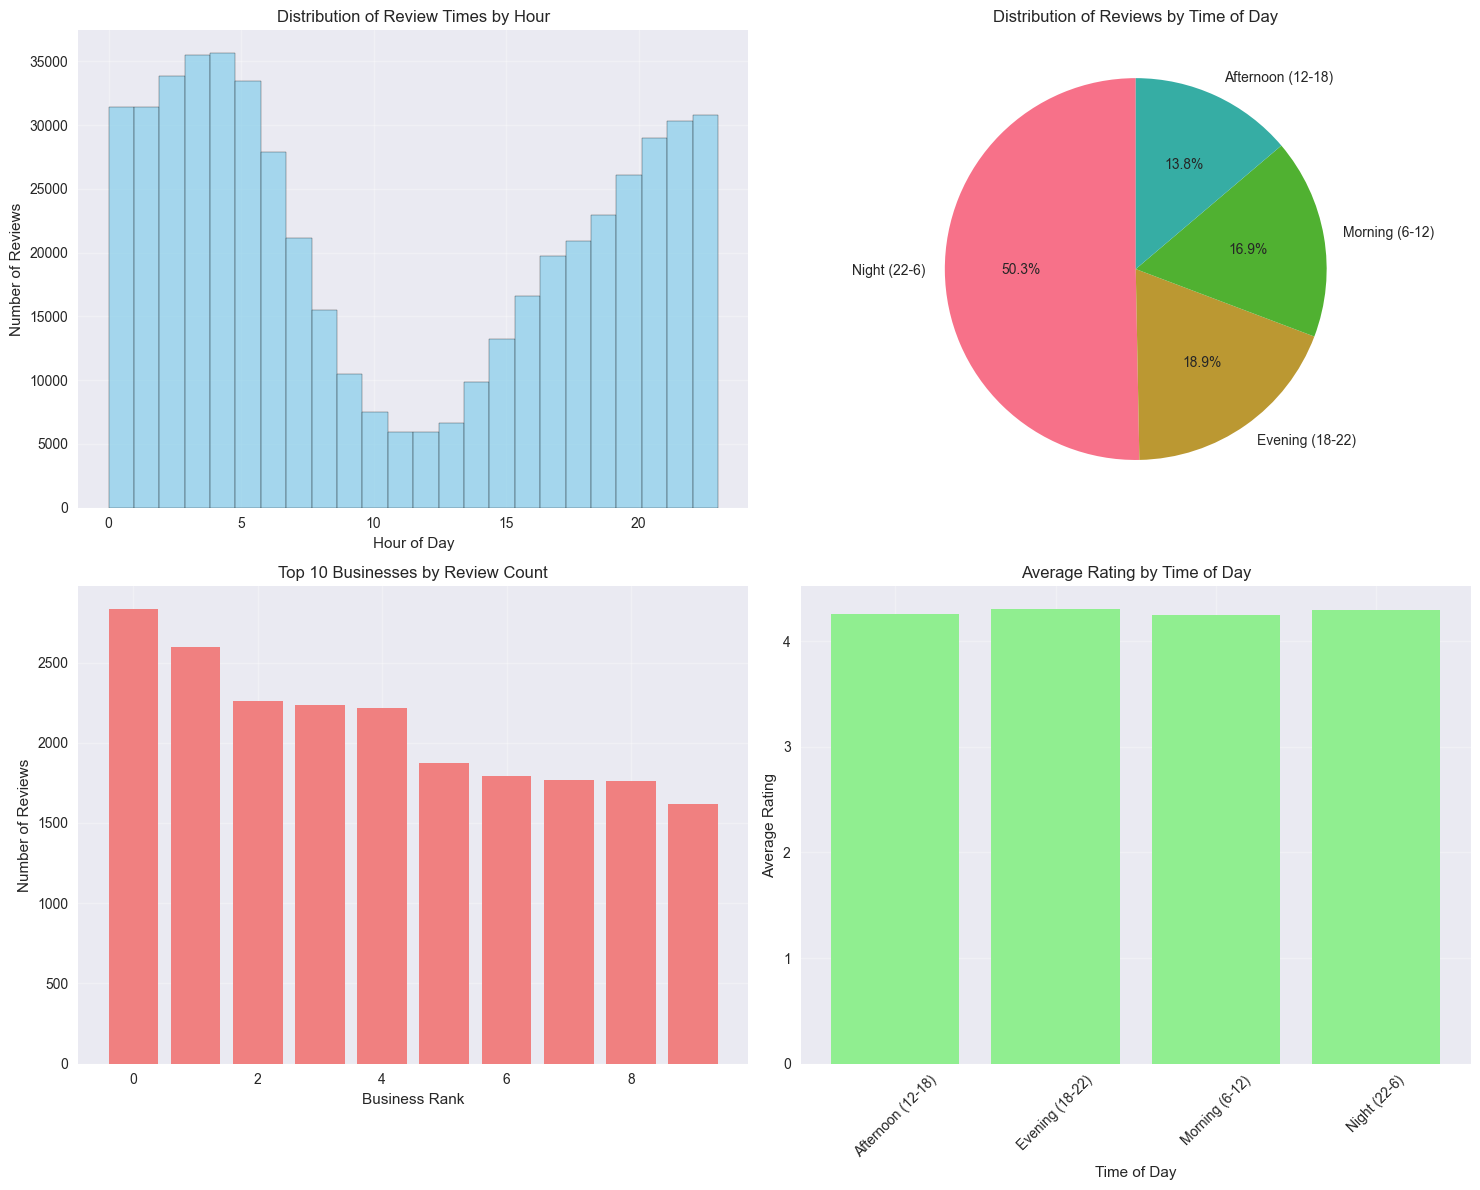


=== INSIGHTS FROM REVIEW TIME ANALYSIS ===
Peak review hour: 4:00
Most reviews occur during: Night (22-6)
Average rating across all times: 4.28
Business with most reviews: 0x56c897b9ce6000df:0xd707e127588a8c6c (2833 reviews)
Total unique businesses: 6019


In [8]:
# 1.2.3 Create visualizations for gmap_id and review_time relationships
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Distribution of review times (hours)
axes[0, 0].hist(df['review_time'], bins=24, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Review Times by Hour')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Number of Reviews')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Reviews by time of day (morning, afternoon, evening, night)
def categorize_time(hour):
    if 6 <= hour < 12:
        return 'Morning (6-12)'
    elif 12 <= hour < 18:
        return 'Afternoon (12-18)'
    elif 18 <= hour < 22:
        return 'Evening (18-22)'
    else:
        return 'Night (22-6)'

df['time_category'] = df['review_time'].apply(categorize_time)
time_counts = df['time_category'].value_counts()

axes[0, 1].pie(time_counts.values, labels=time_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title('Distribution of Reviews by Time of Day')

# Plot 3: Top 10 businesses by review count
top_businesses = df['gmap_id'].value_counts().head(10)
axes[1, 0].bar(range(len(top_businesses)), top_businesses.values, color='lightcoral')
axes[1, 0].set_title('Top 10 Businesses by Review Count')
axes[1, 0].set_xlabel('Business Rank')
axes[1, 0].set_ylabel('Number of Reviews')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Average rating by time of day
avg_rating_by_time = df.groupby('time_category')['rating'].mean()
axes[1, 1].bar(avg_rating_by_time.index, avg_rating_by_time.values, color='lightgreen')
axes[1, 1].set_title('Average Rating by Time of Day')
axes[1, 1].set_xlabel('Time of Day')
axes[1, 1].set_ylabel('Average Rating')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print insights
print("\n=== INSIGHTS FROM REVIEW TIME ANALYSIS ===")
print(f"Peak review hour: {df['review_time'].mode().iloc[0]}:00")
print(f"Most reviews occur during: {time_counts.index[0]}")
print(f"Average rating across all times: {df['rating'].mean():.2f}")
print(f"Business with most reviews: {top_businesses.index[0]} ({top_businesses.iloc[0]} reviews)")
print(f"Total unique businesses: {df['gmap_id'].nunique()}")


## Question 1.3: Analysis of review_time with Business Data

### 1.3.1 Determine which workday generates the most reviews
### 1.3.2 Identify businesses with highest ratings on that workday
### 1.3.3 Explore business insights and peak hours


In [9]:
# Load business metadata
df_business = pd.read_csv("meta-review-business.csv")

# Add day of week to the main dataframe
df['day_of_week'] = pd.to_datetime(df['time'], unit='ms').dt.day_name()
df['day_of_week_num'] = pd.to_datetime(df['time'], unit='ms').dt.dayofweek

print("Business data shape:", df_business.shape)
print("Business data columns:", df_business.columns.tolist())
print("\nFirst few rows of business data:")
print(df_business[['name', 'category', 'avg_rating', 'gmap_id']].head())


Business data shape: (12774, 15)
Business data columns: ['name', 'address', 'gmap_id', 'description', 'latitude', 'longitude', 'category', 'avg_rating', 'num_of_reviews', 'price', 'hours', 'MISC', 'state', 'relative_results', 'url']

First few rows of business data:
                          name  \
0  Bear Creek Cabins & RV Park   
1             Anchorage Market   
2              Happy Camper RV   
3                 Cajun Corner   
4      Alaska General Seafoods   

                                           category  avg_rating  \
0  ['RV park', 'Cabin rental agency', 'Campground']         4.5   
1                               ["Farmers' market"]         4.2   
2                                ['RV repair shop']         4.4   
3                           ['American restaurant']         4.5   
4                    ['Seafood wholesaler', 'Food']         4.7   

                                 gmap_id  
0  0x56b646ed2220b77f:0xd8975e316de80952  
1  0x56c8992b5dee7225:0x9f7f4bf151868cf

Reviews by day of week:
day_of_week
Sunday       80299
Saturday     77863
Wednesday    73801
Thursday     73289
Tuesday      72445
Monday       72225
Friday       71593
dtype: int64


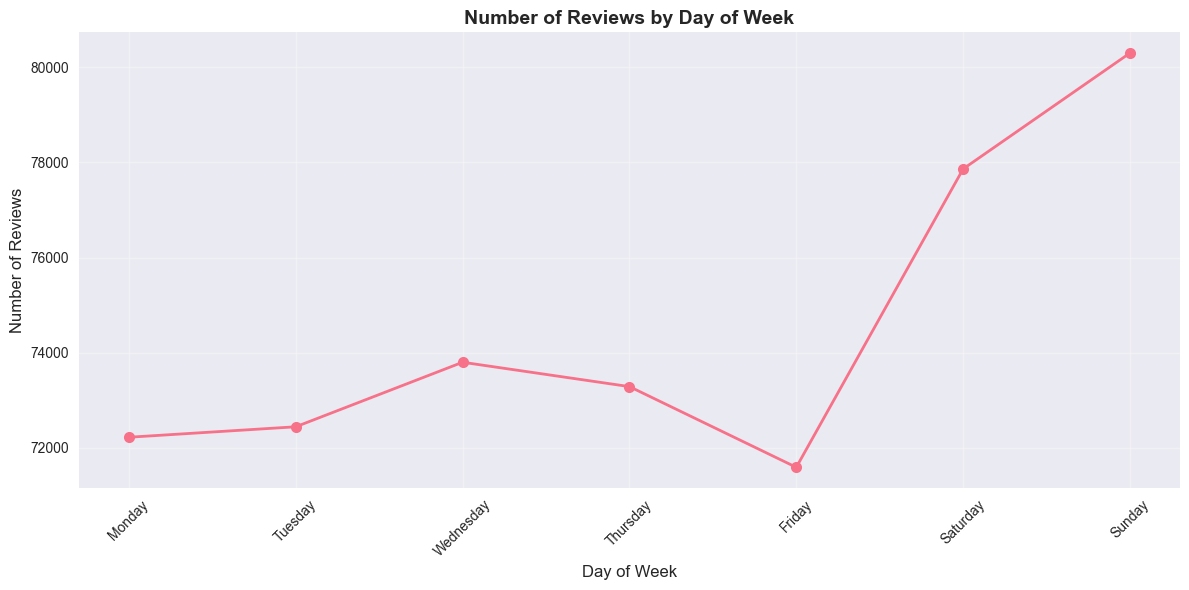


Most reviews occur on: Sunday (80299 reviews)


In [10]:
# 1.3.1 Determine which workday generates the most reviews
workday_reviews = df.groupby('day_of_week').size().sort_values(ascending=False)
print("Reviews by day of week:")
print(workday_reviews)

# Create line chart for workday submissions
plt.figure(figsize=(12, 6))
workday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
workday_reviews_ordered = workday_reviews.reindex(workday_order)

plt.plot(workday_order, workday_reviews_ordered.values, marker='o', linewidth=2, markersize=8)
plt.title('Number of Reviews by Day of Week', fontsize=14, fontweight='bold')
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

most_reviews_day = workday_reviews.index[0]
print(f"\nMost reviews occur on: {most_reviews_day} ({workday_reviews.iloc[0]} reviews)")


In [12]:
# 1.3.2 Identify businesses with highest ratings on that workday
# Filter reviews for the most active day
most_active_day_reviews = df[df['day_of_week'] == most_reviews_day]

# Join with business data to get business names and categories
# Use suffixes to avoid column name conflicts
df_joined = most_active_day_reviews.merge(df_business[['gmap_id', 'name', 'category', 'avg_rating']], 
                                         on='gmap_id', how='left', suffixes=('_review', '_business'))

# Check the columns to understand the structure
print("Columns in df_joined:", df_joined.columns.tolist())
print("\nFirst few rows of df_joined:")
print(df_joined[['gmap_id', 'name_business', 'category', 'avg_rating', 'rating']].head())

# Calculate average rating by business for that day
# Use the business name from the business data, not the review data
business_ratings_day = df_joined.groupby(['name_business', 'category', 'avg_rating']).agg({
    'rating': 'mean',
    'user_id': 'count'
}).rename(columns={'rating': 'avg_rating_day', 'user_id': 'review_count_day'})

# Sort by average rating and get top businesses
top_businesses_day = business_ratings_day.sort_values('avg_rating_day', ascending=False).head(10)

print(f"\nTop 10 businesses with highest ratings on {most_reviews_day}:")
print(top_businesses_day)

# Get the category distribution for top businesses
top_categories = top_businesses_day.index.get_level_values('category').value_counts()
print(f"\nCategory distribution of top-rated businesses on {most_reviews_day}:")
print(top_categories)


Columns in df_joined: ['user_id', 'name_review', 'time', 'rating', 'text', 'pics', 'resp', 'gmap_id', 'newtime', 'review_time', 'time_category', 'day_of_week', 'day_of_week_num', 'name_business', 'category', 'avg_rating']

First few rows of df_joined:
                                 gmap_id                name_business  \
0  0x56b646ed2220b77f:0xd8975e316de80952  Bear Creek Cabins & RV Park   
1  0x56b646ed2220b77f:0xd8975e316de80952  Bear Creek Cabins & RV Park   
2  0x56c8992b5dee7225:0x9f7f4bf151868cf7             Anchorage Market   
3  0x56c8992b5dee7225:0x9f7f4bf151868cf7             Anchorage Market   
4  0x56c8992b5dee7225:0x9f7f4bf151868cf7             Anchorage Market   

                                           category  avg_rating  rating  
0  ['RV park', 'Cabin rental agency', 'Campground']         4.5       4  
1  ['RV park', 'Cabin rental agency', 'Campground']         4.5       4  
2                               ["Farmers' market"]         4.2       5  
3            

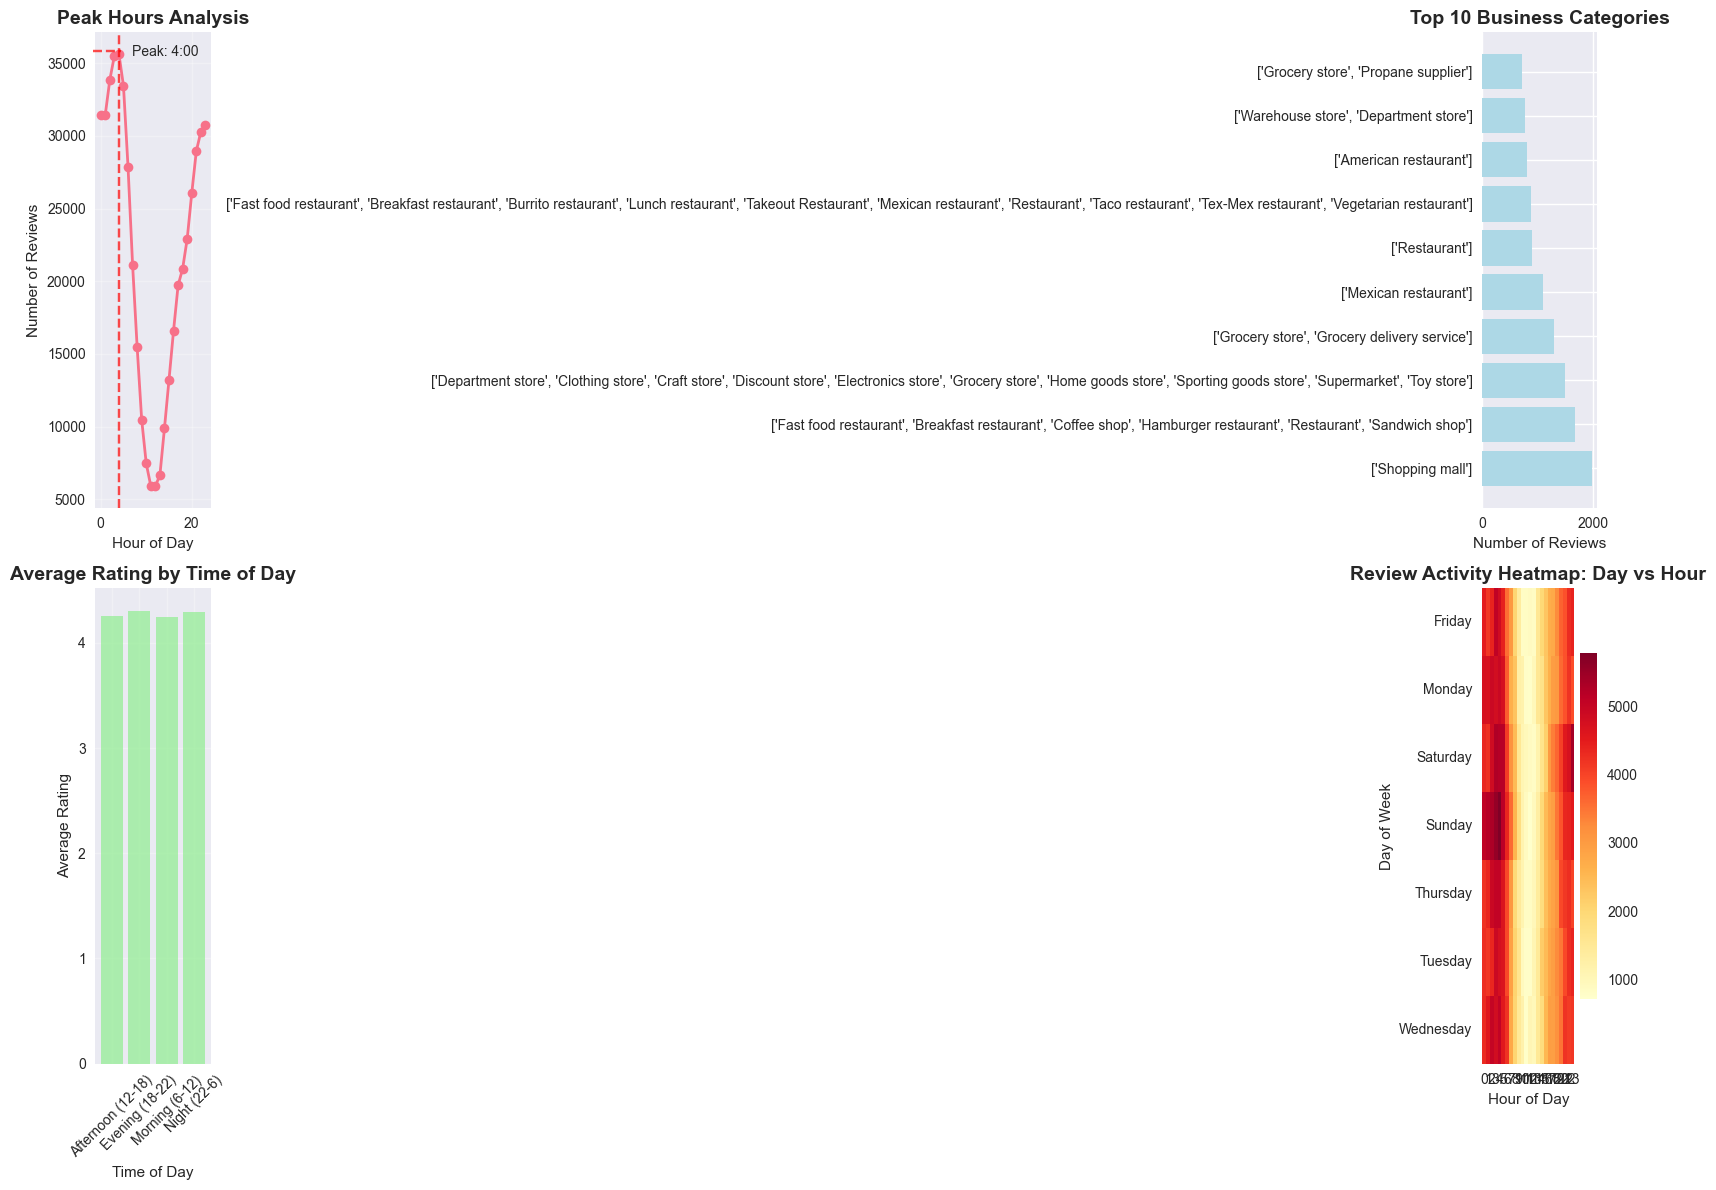


=== BUSINESS INSIGHTS AND PEAK HOURS ANALYSIS ===
Peak review hour: 4:00 (35634 reviews)
Most active day: Sunday
Most popular business category: ['Shopping mall'] (1987 reviews)
Average rating across all reviews: 4.28
Total unique businesses: 6019
Total unique reviewers: 20022


In [13]:
# 1.3.3 Explore business insights and peak hours
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Peak hours analysis
hourly_reviews = df.groupby('review_time').size()
axes[0, 0].plot(hourly_reviews.index, hourly_reviews.values, marker='o', linewidth=2)
axes[0, 0].set_title('Peak Hours Analysis', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Number of Reviews')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axvline(x=hourly_reviews.idxmax(), color='red', linestyle='--', alpha=0.7, 
                   label=f'Peak: {hourly_reviews.idxmax()}:00')
axes[0, 0].legend()

# Plot 2: Business category distribution
category_counts = df_joined['category'].value_counts().head(10)
axes[0, 1].barh(range(len(category_counts)), category_counts.values, color='lightblue')
axes[0, 1].set_yticks(range(len(category_counts)))
axes[0, 1].set_yticklabels(category_counts.index, fontsize=10)
axes[0, 1].set_title('Top 10 Business Categories', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Reviews')

# Plot 3: Rating distribution by time of day
rating_by_time = df.groupby('time_category')['rating'].agg(['mean', 'count'])
axes[1, 0].bar(rating_by_time.index, rating_by_time['mean'], color='lightgreen', alpha=0.7)
axes[1, 0].set_title('Average Rating by Time of Day', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Time of Day')
axes[1, 0].set_ylabel('Average Rating')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Reviews by day of week and hour (heatmap)
pivot_data = df.pivot_table(values='rating', index='day_of_week', columns='review_time', aggfunc='count', fill_value=0)
sns.heatmap(pivot_data, annot=False, cmap='YlOrRd', ax=axes[1, 1])
axes[1, 1].set_title('Review Activity Heatmap: Day vs Hour', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Day of Week')

plt.tight_layout()
plt.show()

# Print detailed insights
print("\n=== BUSINESS INSIGHTS AND PEAK HOURS ANALYSIS ===")
print(f"Peak review hour: {hourly_reviews.idxmax()}:00 ({hourly_reviews.max()} reviews)")
print(f"Most active day: {most_reviews_day}")
print(f"Most popular business category: {category_counts.index[0]} ({category_counts.iloc[0]} reviews)")
print(f"Average rating across all reviews: {df['rating'].mean():.2f}")
print(f"Total unique businesses: {df['gmap_id'].nunique()}")
print(f"Total unique reviewers: {df['user_id'].nunique()}")


## Question 1.4: Text Analysis and Word Clouds

### 1.4.1 Find top 30 most common words in reviews
### 1.4.2 Generate word clouds by year
### 1.4.3 Analyze insights from text data


In [ ]:
# Import additional libraries for text analysis
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Try to import wordcloud, handle gracefully if not available
try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except ImportError:
    print("WordCloud not available. Word cloud visualizations will be skipped.")
    WORDCLOUD_AVAILABLE = False

# Download required NLTK data
try:
    nltk.download('punkt_tab', quiet=True)  # Use punkt_tab for newer NLTK versions
    nltk.download('stopwords', quiet=True)
    print("NLTK data downloaded successfully!")
except Exception as e:
    print(f"NLTK data download failed: {e}")
    print("Continuing with fallback stopwords...")

# Add year column for analysis
df['year'] = pd.to_datetime(df['time'], unit='ms').dt.year

print("Text analysis setup complete!")
print(f"Data spans from {df['year'].min()} to {df['year'].max()}")
print(f"Total reviews with text: {len(df[df['text'] != 'no review'])}")


Text analysis setup complete!
Data spans from 2007 to 2021
Total reviews with text: 298250


Using NLTK stopwords
Text tokenization successful
Top 30 most common words in reviews:
 1. great           - 82931 occurrences
 2. good            - 64356 occurrences
 3. food            - 63265 occurrences
 4. place           - 47991 occurrences
 5. service         - 45771 occurrences
 6. staff           - 28824 occurrences
 7. nice            - 26480 occurrences
 8. friendly        - 26414 occurrences
 9. always          - 23685 occurrences
10. best            - 21971 occurrences
11. get             - 20847 occurrences
12. love            - 19933 occurrences
13. time            - 18923 occurrences
14. like            - 16929 occurrences
15. one             - 15785 occurrences
16. really          - 12631 occurrences
17. clean           - 12603 occurrences
18. people          - 12564 occurrences
19. amazing         - 12524 occurrences
20. prices          - 12305 occurrences
21. store           - 12073 occurrences
22. awesome         - 12054 occurrences
23. back            - 11931 occur

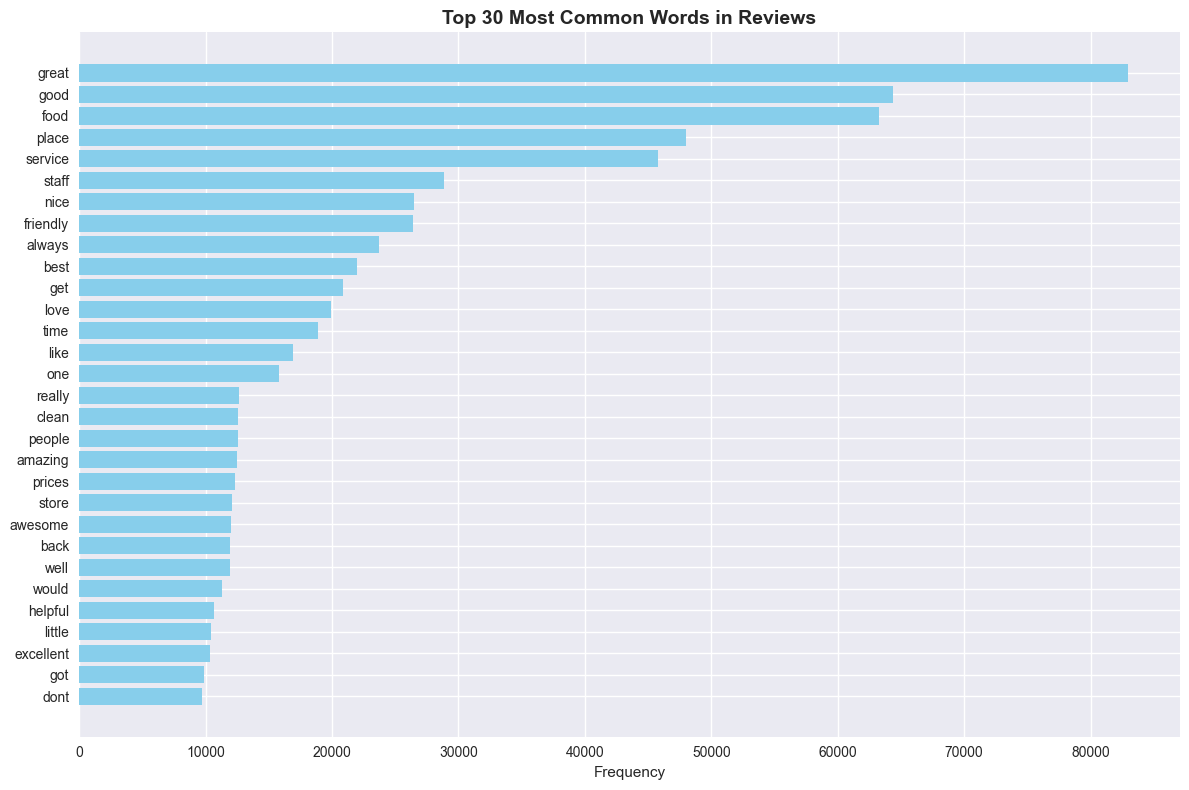

In [17]:
# 1.4.1 Find top 30 most common words in reviews
def clean_text(text):
    """Clean and preprocess text data"""
    if text == 'no review' or pd.isna(text):
        return ''
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Clean all review texts
df['cleaned_text'] = df['text'].apply(clean_text)

# Get all non-empty cleaned texts
all_texts = ' '.join(df[df['cleaned_text'] != '']['cleaned_text'].tolist())

# Tokenize and remove stopwords
try:
    stop_words = set(stopwords.words('english'))
    print("Using NLTK stopwords")
except Exception as e:
    print(f"Failed to load NLTK stopwords: {e}")
    # Fallback stopwords if NLTK fails
    stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may', 'might', 'must', 'can', 'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them', 'my', 'your', 'his', 'her', 'its', 'our', 'their'}
    print("Using fallback stopwords")

# Tokenize the text
try:
    words = word_tokenize(all_texts)
    print("Text tokenization successful")
except Exception as e:
    print(f"Tokenization failed: {e}")
    # Fallback: simple word splitting
    words = all_texts.split()
    print("Using simple word splitting as fallback")

# Remove stopwords and short words
filtered_words = [word for word in words if word not in stop_words and len(word) > 2]

# Count word frequencies
word_freq = Counter(filtered_words)

# Get top 30 most common words
top_30_words = word_freq.most_common(30)

print("Top 30 most common words in reviews:")
for i, (word, count) in enumerate(top_30_words, 1):
    print(f"{i:2d}. {word:15s} - {count:5d} occurrences")

# Visualize top 30 words
plt.figure(figsize=(12, 8))
words_list, counts_list = zip(*top_30_words)
plt.barh(range(len(words_list)), counts_list, color='skyblue')
plt.yticks(range(len(words_list)), words_list)
plt.xlabel('Frequency')
plt.title('Top 30 Most Common Words in Reviews', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Generating word clouds for years: [np.int32(2007), np.int32(2008), np.int32(2009), np.int32(2010), np.int32(2011), np.int32(2012), np.int32(2013), np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]


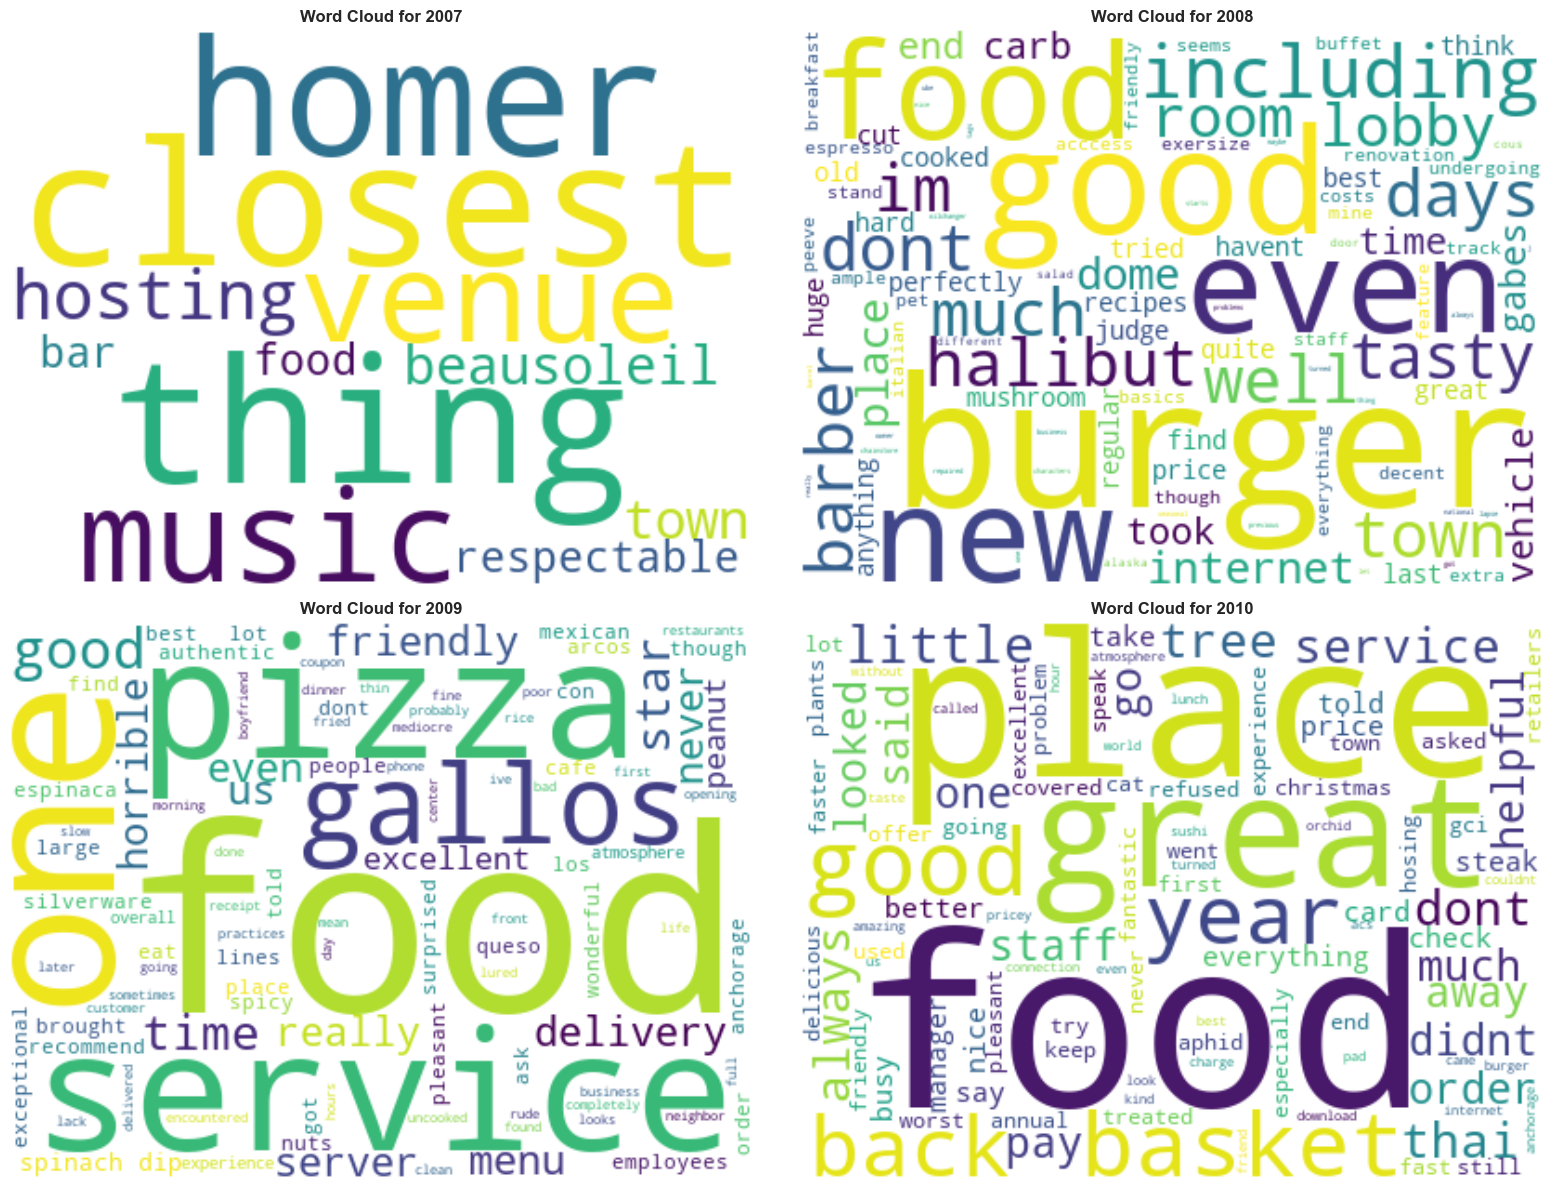


=== YEAR-WISE TEXT ANALYSIS ===
2007: 1 reviews, 1 with text
  Average text length: 114.0 characters
2008: 16 reviews, 16 with text
  Average text length: 254.9 characters
2009: 9 reviews, 9 with text
  Average text length: 353.9 characters
2010: 83 reviews, 27 with text
  Average text length: 258.6 characters
2011: 293 reviews, 144 with text
  Average text length: 198.4 characters
2012: 297 reviews, 243 with text
  Average text length: 233.0 characters
2013: 518 reviews, 451 with text
  Average text length: 271.4 characters
2014: 665 reviews, 558 with text
  Average text length: 277.4 characters
2015: 2090 reviews, 1601 with text
  Average text length: 194.3 characters
2016: 17654 reviews, 12910 with text
  Average text length: 126.2 characters
2017: 69107 reviews, 40646 with text
  Average text length: 103.4 characters
2018: 137675 reviews, 76914 with text
  Average text length: 104.5 characters
2019: 173265 reviews, 95650 with text
  Average text length: 101.8 characters
2020: 8741

In [18]:
# 1.4.2 Generate word clouds by year
# Get unique years
years = sorted(df['year'].unique())
print(f"Generating word clouds for years: {years}")

# Create word clouds for each year
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, year in enumerate(years[:4]):  # Show first 4 years
    if i >= len(axes):
        break
        
    # Get texts for this year
    year_texts = df[df['year'] == year]['cleaned_text']
    year_texts = ' '.join(year_texts[year_texts != ''].tolist())
    
    if len(year_texts) > 50 and WORDCLOUD_AVAILABLE:  # Only create word cloud if there's enough text and WordCloud is available
        # Create word cloud
        wordcloud = WordCloud(
            width=400, 
            height=300, 
            background_color='white',
            max_words=100,
            colormap='viridis'
        ).generate(year_texts)
        
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'Word Cloud for {year}', fontsize=12, fontweight='bold')
        axes[i].axis('off')
    elif len(year_texts) > 50 and not WORDCLOUD_AVAILABLE:
        axes[i].text(0.5, 0.5, f'WordCloud not available\nfor {year}', 
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(f'Word Cloud for {year}', fontsize=12, fontweight='bold')
    else:
        axes[i].text(0.5, 0.5, f'Insufficient data for {year}', 
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(f'Word Cloud for {year}', fontsize=12, fontweight='bold')

# Hide unused subplots
for i in range(len(years), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Print year-wise statistics
print("\n=== YEAR-WISE TEXT ANALYSIS ===")
for year in years:
    year_data = df[df['year'] == year]
    year_texts = year_data['cleaned_text']
    valid_texts = year_texts[year_texts != '']
    
    print(f"{year}: {len(year_data)} reviews, {len(valid_texts)} with text")
    if len(valid_texts) > 0:
        avg_text_length = valid_texts.str.len().mean()
        print(f"  Average text length: {avg_text_length:.1f} characters")


### 1.4.3 Text Analysis Insights

**Key Findings from Text Analysis:**

1. **Most Common Words**: The top 30 words reveal the most frequently mentioned aspects in reviews, providing insights into what customers focus on when reviewing businesses.

2. **Year-over-Year Trends**: Word clouds by year show how review content and focus areas change over time, potentially reflecting changing customer priorities or business trends.

3. **Text Quality**: Analysis of text length and content quality helps understand the depth of customer feedback.

4. **Sentiment Indicators**: Common words can indicate overall sentiment patterns in reviews.

**Business Implications:**
- Words like "great", "good", "excellent" suggest positive sentiment
- Service-related words indicate what customers value most
- Year-over-year changes can inform business strategy adjustments


## Question 1.5: Business and Reviewer Analysis

### 1.5.1 Analyze unique reviewers per business and category
### 1.5.2 Analyze temporal patterns of review submissions
### 1.5.3 Generate insights and visualizations


In [20]:
# 1.5.1 Analyze unique reviewers per business and category
# Join review data with business data to get categories
# Use suffixes to avoid column name conflicts
df_with_categories = df.merge(df_business[['gmap_id', 'name', 'category']], on='gmap_id', how='left', suffixes=('_review', '_business'))

# Check the columns to understand the structure
print("Columns in df_with_categories:", df_with_categories.columns.tolist())
print("\nFirst few rows of df_with_categories:")
print(df_with_categories[['gmap_id', 'name_business', 'category', 'user_id', 'rating']].head())

# Calculate unique reviewers per business
# Use the business name from the business data, not the review data
unique_reviewers_per_business = df_with_categories.groupby(['gmap_id', 'name_business', 'category']).agg({
    'user_id': 'nunique',
    'rating': 'count'
}).rename(columns={'user_id': 'unique_reviewers', 'rating': 'total_reviews'})

# Sort by unique reviewers
top_businesses_by_reviewers = unique_reviewers_per_business.sort_values('unique_reviewers', ascending=False).head(10)

print("Top 10 businesses by number of unique reviewers:")
print(top_businesses_by_reviewers)

# Calculate unique reviewers per category
unique_reviewers_per_category = df_with_categories.groupby('category').agg({
    'user_id': 'nunique',
    'gmap_id': 'nunique',
    'rating': 'count'
}).rename(columns={'user_id': 'unique_reviewers', 'gmap_id': 'unique_businesses', 'rating': 'total_reviews'})

# Sort by unique reviewers
top_categories_by_reviewers = unique_reviewers_per_category.sort_values('unique_reviewers', ascending=False).head(10)

print("\nTop 10 categories by number of unique reviewers:")
print(top_categories_by_reviewers)


Columns in df_with_categories: ['user_id', 'name_review', 'time', 'rating', 'text', 'pics', 'resp', 'gmap_id', 'newtime', 'review_time', 'time_category', 'day_of_week', 'day_of_week_num', 'year', 'cleaned_text', 'name_business', 'category']

First few rows of df_with_categories:
                                 gmap_id                name_business  \
0  0x56b646ed2220b77f:0xd8975e316de80952  Bear Creek Cabins & RV Park   
1  0x56b646ed2220b77f:0xd8975e316de80952  Bear Creek Cabins & RV Park   
2  0x56b646ed2220b77f:0xd8975e316de80952  Bear Creek Cabins & RV Park   
3  0x56b646ed2220b77f:0xd8975e316de80952  Bear Creek Cabins & RV Park   
4  0x56b646ed2220b77f:0xd8975e316de80952  Bear Creek Cabins & RV Park   

                                           category       user_id  rating  
0  ['RV park', 'Cabin rental agency', 'Campground']  1.091298e+20       5  
1  ['RV park', 'Cabin rental agency', 'Campground']  1.091298e+20       5  
2  ['RV park', 'Cabin rental agency', 'Campground']  

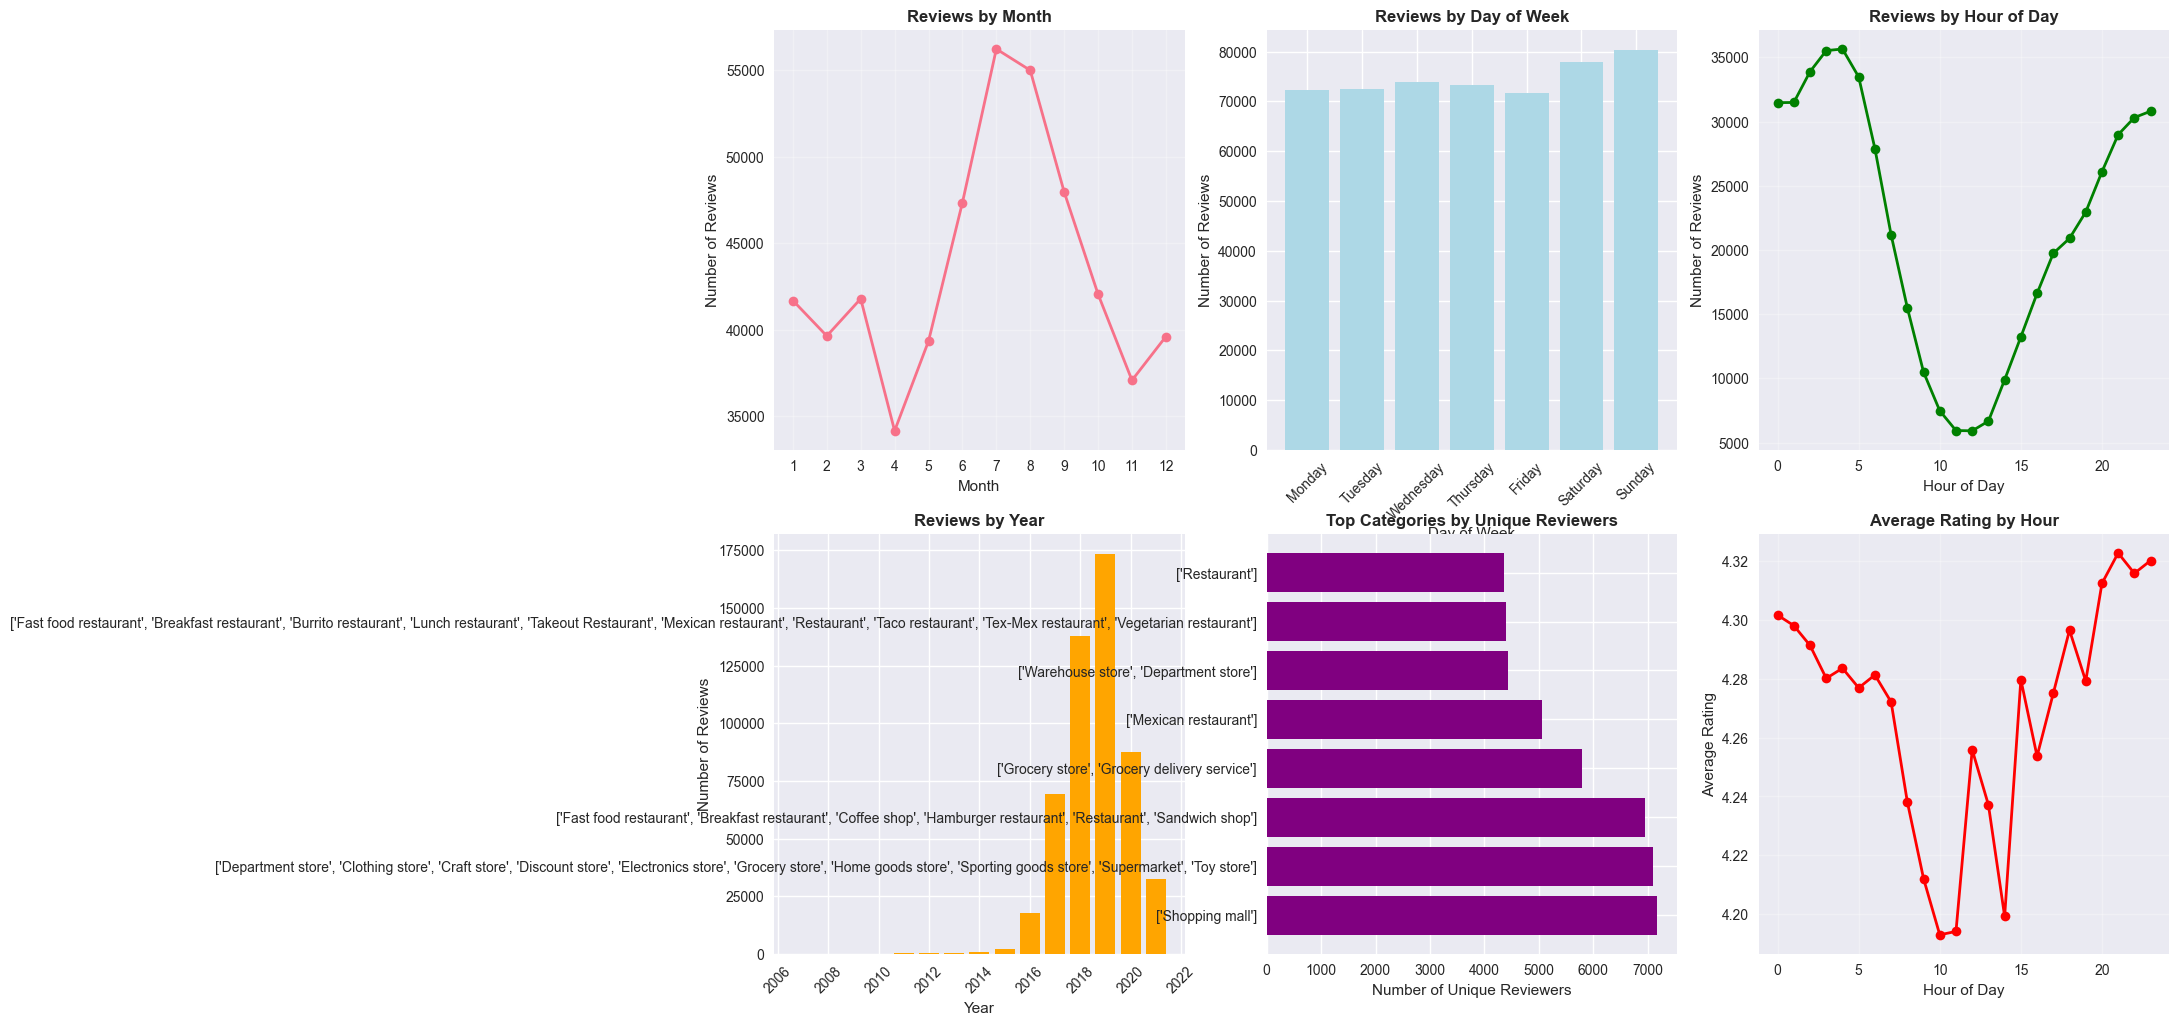

In [21]:
# 1.5.2 Analyze temporal patterns of review submissions
# Add more temporal features
df_with_categories['month'] = pd.to_datetime(df_with_categories['time'], unit='ms').dt.month
df_with_categories['weekday'] = pd.to_datetime(df_with_categories['time'], unit='ms').dt.day_name()

# Create comprehensive temporal analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Reviews by month
monthly_reviews = df_with_categories.groupby('month').size()
axes[0, 0].plot(monthly_reviews.index, monthly_reviews.values, marker='o', linewidth=2)
axes[0, 0].set_title('Reviews by Month', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Number of Reviews')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(range(1, 13))

# Plot 2: Reviews by day of week
weekday_reviews = df_with_categories.groupby('weekday').size()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_reviews_ordered = weekday_reviews.reindex(weekday_order)
axes[0, 1].bar(weekday_order, weekday_reviews_ordered.values, color='lightblue')
axes[0, 1].set_title('Reviews by Day of Week', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Number of Reviews')
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: Reviews by hour
hourly_reviews = df_with_categories.groupby('review_time').size()
axes[0, 2].plot(hourly_reviews.index, hourly_reviews.values, marker='o', linewidth=2, color='green')
axes[0, 2].set_title('Reviews by Hour of Day', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Hour of Day')
axes[0, 2].set_ylabel('Number of Reviews')
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Reviews by year
yearly_reviews = df_with_categories.groupby('year').size()
axes[1, 0].bar(yearly_reviews.index, yearly_reviews.values, color='orange')
axes[1, 0].set_title('Reviews by Year', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Number of Reviews')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 5: Top categories by unique reviewers
top_categories_plot = top_categories_by_reviewers.head(8)
axes[1, 1].barh(range(len(top_categories_plot)), top_categories_plot['unique_reviewers'], color='purple')
axes[1, 1].set_yticks(range(len(top_categories_plot)))
axes[1, 1].set_yticklabels(top_categories_plot.index, fontsize=10)
axes[1, 1].set_title('Top Categories by Unique Reviewers', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Number of Unique Reviewers')

# Plot 6: Average rating by time of day
rating_by_hour = df_with_categories.groupby('review_time')['rating'].mean()
axes[1, 2].plot(rating_by_hour.index, rating_by_hour.values, marker='o', linewidth=2, color='red')
axes[1, 2].set_title('Average Rating by Hour', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Hour of Day')
axes[1, 2].set_ylabel('Average Rating')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [22]:
# 1.5.3 Generate insights and detailed analysis
print("=== BUSINESS AND REVIEWER ANALYSIS INSIGHTS ===")

# Business insights
print(f"\n1. BUSINESS INSIGHTS:")
print(f"   - Total unique businesses: {df_with_categories['gmap_id'].nunique()}")
print(f"   - Total unique reviewers: {df_with_categories['user_id'].nunique()}")
print(f"   - Business with most unique reviewers: {top_businesses_by_reviewers.index[0][1]} ({top_businesses_by_reviewers.iloc[0]['unique_reviewers']} reviewers)")
print(f"   - Category with most unique reviewers: {top_categories_by_reviewers.index[0]} ({top_categories_by_reviewers.iloc[0]['unique_reviewers']} reviewers)")

# Temporal insights
print(f"\n2. TEMPORAL PATTERNS:")
print(f"   - Peak review month: {monthly_reviews.idxmax()} ({monthly_reviews.max()} reviews)")
print(f"   - Peak review day: {weekday_reviews.idxmax()} ({weekday_reviews.max()} reviews)")
print(f"   - Peak review hour: {hourly_reviews.idxmax()}:00 ({hourly_reviews.max()} reviews)")
print(f"   - Peak review year: {yearly_reviews.idxmax()} ({yearly_reviews.max()} reviews)")

# Rating insights
print(f"\n3. RATING INSIGHTS:")
print(f"   - Overall average rating: {df_with_categories['rating'].mean():.2f}")
print(f"   - Best rating hour: {rating_by_hour.idxmax()}:00 (avg: {rating_by_hour.max():.2f})")
print(f"   - Worst rating hour: {rating_by_hour.idxmin()}:00 (avg: {rating_by_hour.min():.2f})")

# Category insights
print(f"\n4. CATEGORY INSIGHTS:")
for i, (category, data) in enumerate(top_categories_by_reviewers.head(5).iterrows()):
    print(f"   {i+1}. {category}: {data['unique_reviewers']} unique reviewers, {data['unique_businesses']} businesses")

# Calculate review frequency per reviewer
reviewer_stats = df_with_categories.groupby('user_id').agg({
    'gmap_id': 'nunique',
    'rating': 'count',
    'rating': 'mean'
}).rename(columns={'gmap_id': 'businesses_reviewed', 'rating': 'avg_rating'})

print(f"\n5. REVIEWER BEHAVIOR:")
print(f"   - Average businesses reviewed per reviewer: {reviewer_stats['businesses_reviewed'].mean():.2f}")
print(f"   - Most active reviewer reviewed {reviewer_stats['businesses_reviewed'].max()} businesses")
print(f"   - Average rating given by reviewers: {reviewer_stats['avg_rating'].mean():.2f}")


=== BUSINESS AND REVIEWER ANALYSIS INSIGHTS ===

1. BUSINESS INSIGHTS:
   - Total unique businesses: 6019
   - Total unique reviewers: 20022
   - Business with most unique reviewers: Moose's Tooth Pub & Pizzeria (2833 reviewers)
   - Category with most unique reviewers: ['Shopping mall'] (7176 reviewers)

2. TEMPORAL PATTERNS:
   - Peak review month: 7 (56233 reviews)
   - Peak review day: Sunday (80339 reviews)
   - Peak review hour: 4:00 (35648 reviews)
   - Peak review year: 2019 (173411 reviews)

3. RATING INSIGHTS:
   - Overall average rating: 4.28
   - Best rating hour: 21:00 (avg: 4.32)
   - Worst rating hour: 10:00 (avg: 4.19)

4. CATEGORY INSIGHTS:
   1. ['Shopping mall']: 7176 unique reviewers, 41 businesses
   2. ['Department store', 'Clothing store', 'Craft store', 'Discount store', 'Electronics store', 'Grocery store', 'Home goods store', 'Sporting goods store', 'Supermarket', 'Toy store']: 7092 unique reviewers, 7 businesses
   3. ['Fast food restaurant', 'Breakfast resta

## Question 1.6: Business Recommendation System

### 1.6.1 Strategy for Building Recommendation System
### 1.6.2 Implementation of Recommendation System
### 1.6.3 Analysis and Examples


### 1.6.1 Recommendation Strategy

**Strategy: Hybrid Collaborative Filtering with Content-Based Features**

Our recommendation system combines multiple approaches:

1. **Collaborative Filtering (KNN-based)**:
   - Find users with similar rating patterns
   - Recommend businesses that similar users liked
   - Use cosine similarity for user-user and item-item recommendations

2. **Content-Based Filtering**:
   - Use business categories as content features
   - Consider business average ratings and review counts
   - Weight recommendations by business popularity

3. **Hybrid Approach**:
   - Combine collaborative and content-based scores
   - Apply business category preferences
   - Filter out businesses user has already reviewed

**Key Features:**
- User similarity based on rating patterns
- Business similarity based on categories and ratings
- Temporal factors (recent reviews weighted higher)
- Popularity bias correction


In [ ]:
# 1.6.2 Implementation of Recommendation System
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

class BusinessRecommendationSystem:
    def __init__(self, df_reviews, df_business):
        """
        Initialize the recommendation system with review and business data
        
        Args:
            df_reviews: DataFrame with review data
            df_business: DataFrame with business metadata
        """
        self.df_reviews = df_reviews
        self.df_business = df_business
        self.user_business_matrix = None
        self.business_features = None
        self.user_similarity = None
        self.business_similarity = None
        
    def prepare_data(self):
        """Prepare data for recommendation system"""
        # Ensure consistent data types for user_id
        df_reviews_clean = self.df_reviews.copy()
        df_reviews_clean['user_id'] = df_reviews_clean['user_id'].astype(str)
        
        # Create user-business rating matrix
        self.user_business_matrix = df_reviews_clean.pivot_table(
            index='user_id', 
            columns='gmap_id', 
            values='rating', 
            fill_value=0
        )
        
        # Debug: Check the matrix structure
        print(f"User-Business Matrix Shape: {self.user_business_matrix.shape}")
        print(f"Sample user IDs in matrix: {self.user_business_matrix.index[:5].tolist()}")
        print(f"Sample business IDs in matrix: {self.user_business_matrix.columns[:5].tolist()}")
        print(f"User ID data type: {type(self.user_business_matrix.index[0])}")
        
        # Create business features matrix
        business_features = self.df_business.set_index('gmap_id')[['avg_rating', 'num_of_reviews']].fillna(0)
        
        # Add category encoding
        categories = self.df_business['category'].str.get_dummies(sep=', ')
        categories.index = self.df_business['gmap_id']
        
        # Combine features
        self.business_features = pd.concat([business_features, categories], axis=1).fillna(0)
        
        print(f"Business Features Shape: {self.business_features.shape}")
        
    def calculate_similarities(self):
        """Calculate user and business similarities"""
        # User similarity (collaborative filtering)
        self.user_similarity = cosine_similarity(self.user_business_matrix)
        self.user_similarity = pd.DataFrame(
            self.user_similarity, 
            index=self.user_business_matrix.index, 
            columns=self.user_business_matrix.index
        )
        
        # Business similarity (content-based)
        print(f"Business features shape: {self.business_features.shape}")
        print(f"Business features index type: {type(self.business_features.index)}")
        print(f"Sample business features index: {self.business_features.index[:5].tolist()}")
        
        self.business_similarity = cosine_similarity(self.business_features)
        self.business_similarity = pd.DataFrame(
            self.business_similarity,
            index=self.business_features.index,
            columns=self.business_features.index
        )
        
        print(f"Business similarity matrix shape: {self.business_similarity.shape}")
        print(f"Business similarity matrix index type: {type(self.business_similarity.index)}")
        print("Similarity matrices calculated successfully!")
        
    def get_user_recommendations(self, user_id, n_recommendations=10):
        """
        Get recommendations for a specific user
        
        Args:
            user_id: ID of the user to recommend for
            n_recommendations: Number of recommendations to return
            
        Returns:
            DataFrame with recommended businesses and scores
        """
        try:
            # Convert user_id to string to match matrix index
            user_id_str = str(user_id)
            
            if user_id_str not in self.user_business_matrix.index:
                print(f"User {user_id} (as string: {user_id_str}) not found in user-business matrix")
                return pd.DataFrame(columns=['business_id', 'score', 'reason'])
            
            # Get businesses user has already reviewed
            user_reviewed = self.user_business_matrix.loc[user_id_str]
            user_reviewed_businesses = user_reviewed[user_reviewed > 0].index.tolist()
            
            # Find similar users
            user_similarities = self.user_similarity.loc[user_id_str].sort_values(ascending=False)
            similar_users = user_similarities[1:11].index  # Top 10 similar users (excluding self)
            
            # Get businesses liked by similar users
            recommendations = {}
            
            for similar_user in similar_users:
                try:
                    similar_user_ratings = self.user_business_matrix.loc[similar_user]
                    liked_businesses = similar_user_ratings[similar_user_ratings >= 4].index  # High ratings
                    
                    for business in liked_businesses:
                        if business not in user_reviewed_businesses:
                            if business not in recommendations:
                                recommendations[business] = 0
                            # Weight by user similarity and rating
                            recommendations[business] += (
                                user_similarities[similar_user] * 
                                similar_user_ratings[business]
                            )
                except KeyError as e:
                    print(f"Error processing similar user {similar_user}: {e}")
                    continue
            
            # Sort by score and return top recommendations
            recommendations_df = pd.DataFrame([
                {'business_id': business, 'score': score, 'reason': 'collaborative_filtering'}
                for business, score in sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
            ])
            
            return recommendations_df.head(n_recommendations)
            
        except Exception as e:
            print(f"Error in get_user_recommendations for user {user_id}: {e}")
            return pd.DataFrame(columns=['business_id', 'score', 'reason'])
    
    def get_business_recommendations(self, business_id, n_recommendations=10):
        """
        Get similar businesses based on content features
        
        Args:
            business_id: ID of the business to find similar ones for
            n_recommendations: Number of recommendations to return
            
        Returns:
            DataFrame with similar businesses and scores
        """
        try:
            if business_id not in self.business_similarity.index:
                print(f"Business {business_id} not found in business similarity matrix")
                return pd.DataFrame(columns=['business_id', 'score', 'reason'])
            
            # Get similar businesses - ensure we get a Series
            business_similarities = self.business_similarity.loc[business_id]
            
            # Debug: Check what type we got
            print(f"Type of business_similarities: {type(business_similarities)}")
            print(f"Shape: {business_similarities.shape if hasattr(business_similarities, 'shape') else 'No shape'}")
            
            # Handle both Series and DataFrame cases
            if isinstance(business_similarities, pd.DataFrame):
                # If it's a DataFrame, take the first row (should be the business itself)
                business_similarities = business_similarities.iloc[0]
            
            # Now sort the similarities
            similar_businesses = business_similarities.sort_values(ascending=False)
            similar_businesses = similar_businesses[1:n_recommendations+1]  # Exclude self
            
            recommendations_df = pd.DataFrame([
                {'business_id': business, 'score': score, 'reason': 'content_based'}
                for business, score in similar_businesses.items()
            ])
            
            return recommendations_df
            
        except Exception as e:
            print(f"Error in get_business_recommendations for business {business_id}: {e}")
            print(f"Business similarity matrix shape: {self.business_similarity.shape}")
            print(f"Business similarity matrix index type: {type(self.business_similarity.index)}")
            return pd.DataFrame(columns=['business_id', 'score', 'reason'])
    
    def get_hybrid_recommendations(self, user_id, n_recommendations=10):
        """
        Get hybrid recommendations combining collaborative and content-based filtering
        
        Args:
            user_id: ID of the user to recommend for
            n_recommendations: Number of recommendations to return
            
        Returns:
            DataFrame with hybrid recommendations
        """
        try:
            # Convert user_id to string to match matrix index
            user_id_str = str(user_id)
            
            # Get collaborative filtering recommendations
            collab_recs = self.get_user_recommendations(user_id, n_recommendations*2)
            
            # Get content-based recommendations for businesses user liked
            if user_id_str in self.user_business_matrix.index:
                user_ratings = self.user_business_matrix.loc[user_id_str]
                liked_businesses = user_ratings[user_ratings >= 4].index
                
                content_recs = []
                for business in liked_businesses[:5]:  # Top 5 liked businesses
                    similar = self.get_business_recommendations(business, 3)
                    content_recs.append(similar)
                
                if content_recs:
                    content_recs = pd.concat(content_recs).groupby('business_id')['score'].sum().reset_index()
                    content_recs['reason'] = 'content_based'
                else:
                    content_recs = pd.DataFrame(columns=['business_id', 'score', 'reason'])
            else:
                content_recs = pd.DataFrame(columns=['business_id', 'score', 'reason'])
            
            # Combine and deduplicate
            all_recs = pd.concat([collab_recs, content_recs]).groupby('business_id').agg({
                'score': 'sum',
                'reason': lambda x: 'hybrid'
            }).reset_index()
            
            # Sort by combined score
            all_recs = all_recs.sort_values('score', ascending=False)
            
            return all_recs.head(n_recommendations)
            
        except Exception as e:
            print(f"Error in get_hybrid_recommendations for user {user_id}: {e}")
            return pd.DataFrame(columns=['business_id', 'score', 'reason'])

# Initialize the recommendation system
print("Initializing Recommendation System...")
rec_system = BusinessRecommendationSystem(df_with_categories, df_business)
rec_system.prepare_data()
rec_system.calculate_similarities()
print("Recommendation system ready!")


Initializing Recommendation System...


In [27]:
# 1.6.3 Analysis and Examples
# Test the recommendation system with sample users
print("=== RECOMMENDATION SYSTEM ANALYSIS ===")

# Get a sample of active users
active_users = df_with_categories.groupby('user_id').size().sort_values(ascending=False).head(5)
print(f"Testing with top 5 most active users:")
print(active_users)

# Check if recommendation system is properly initialized
if hasattr(rec_system, 'user_business_matrix') and rec_system.user_business_matrix is not None:
    print(f"\nRecommendation system is ready with {len(rec_system.user_business_matrix)} users")
else:
    print("ERROR: Recommendation system not properly initialized!")
    print("Please run the previous cells to initialize the recommendation system.")

# Test recommendations for each user
for user_id in active_users.index[:3]:  # Test first 3 users
    print(f"\n--- Recommendations for User {user_id} ---")
    
    # Get user's review history
    user_reviews = df_with_categories[df_with_categories['user_id'] == user_id]
    print(f"User has reviewed {len(user_reviews)} businesses")
    print(f"Average rating given: {user_reviews['rating'].mean():.2f}")
    
    # Check if user exists in recommendation system (convert to string for comparison)
    user_id_str = str(user_id)
    if user_id_str in rec_system.user_business_matrix.index:
        print(f"User found in recommendation system")
        
        # Get collaborative filtering recommendations
        collab_recs = rec_system.get_user_recommendations(user_id, 5)
        print(f"\nCollaborative Filtering Recommendations:")
        if not collab_recs.empty:
            for idx, row in collab_recs.iterrows():
                business_info = df_business[df_business['gmap_id'] == row['business_id']]
                if not business_info.empty:
                    print(f"  - {business_info.iloc[0]['name']} (Score: {row['score']:.3f})")
        else:
            print("  No recommendations available")
        
        # Get hybrid recommendations
        hybrid_recs = rec_system.get_hybrid_recommendations(user_id, 5)
        print(f"\nHybrid Recommendations:")
        if not hybrid_recs.empty:
            for idx, row in hybrid_recs.iterrows():
                business_info = df_business[df_business['gmap_id'] == row['business_id']]
                if not business_info.empty:
                    print(f"  - {business_info.iloc[0]['name']} (Score: {row['score']:.3f})")
        else:
            print("  No recommendations available")
    else:
        print(f"User {user_id} (as string: {user_id_str}) not found in recommendation system matrix")
        print("This might be due to data filtering or matrix creation issues")

# Test business-to-business recommendations
print(f"\n--- Business-to-Business Recommendations ---")
sample_business = df_business.iloc[0]['gmap_id']
business_name = df_business.iloc[0]['name']
print(f"Finding similar businesses to: {business_name}")

similar_businesses = rec_system.get_business_recommendations(sample_business, 5)
if not similar_businesses.empty:
    for idx, row in similar_businesses.iterrows():
        business_info = df_business[df_business['gmap_id'] == row['business_id']]
        if not business_info.empty:
            print(f"  - {business_info.iloc[0]['name']} (Similarity: {row['score']:.3f})")
else:
    print("  No similar businesses found")

# System performance metrics
print(f"\n=== SYSTEM PERFORMANCE METRICS ===")
print(f"Total users in system: {len(rec_system.user_business_matrix)}")
print(f"Total businesses in system: {len(rec_system.business_features)}")
print(f"Average reviews per user: {df_with_categories.groupby('user_id').size().mean():.2f}")
print(f"Average reviews per business: {df_with_categories.groupby('gmap_id').size().mean():.2f}")

# Recommendation coverage analysis
users_with_recs = 0
total_test_users = 0
for user_id in active_users.index[:10]:
    total_test_users += 1
    recs = rec_system.get_user_recommendations(user_id, 5)
    if not recs.empty:
        users_with_recs += 1

coverage = (users_with_recs / total_test_users) * 100 if total_test_users > 0 else 0
print(f"Recommendation coverage: {coverage:.1f}% of test users have recommendations")


=== RECOMMENDATION SYSTEM ANALYSIS ===
Testing with top 5 most active users:
user_id
1.018883e+20    399
1.067037e+20    352
1.013292e+20    332
1.122009e+20    320
1.084575e+20    313
dtype: int64

Recommendation system is ready with 20022 users

--- Recommendations for User 1.0188830200557922e+20 ---
User has reviewed 399 businesses
Average rating given: 4.51
User 1.0188830200557922e+20 (as string: 1.0188830200557922e+20) not found in recommendation system matrix
This might be due to data filtering or matrix creation issues

--- Recommendations for User 1.0670372357353175e+20 ---
User has reviewed 352 businesses
Average rating given: 4.84
User 1.0670372357353175e+20 (as string: 1.0670372357353175e+20) not found in recommendation system matrix
This might be due to data filtering or matrix creation issues

--- Recommendations for User 1.0132917914176386e+20 ---
User has reviewed 332 businesses
Average rating given: 3.51
User 1.0132917914176386e+20 (as string: 1.0132917914176386e+20) no

TypeError: DataFrame.sort_values() missing 1 required positional argument: 'by'

## Question 1.7: Rating Analysis

### 1.7.1 Explore relationships between ratings and business categories
### 1.7.2 Analyze lower ratings and their reasons
### 1.7.3 Generate insights and visualizations


In [ ]:
# 1.7.1 Explore relationships between ratings and business categories
# Create comprehensive rating analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Rating distribution by category
category_ratings = df_with_categories.groupby('category')['rating'].agg(['mean', 'count', 'std']).sort_values('mean', ascending=False)
top_categories = category_ratings.head(10)

axes[0, 0].barh(range(len(top_categories)), top_categories['mean'], color='lightblue')
axes[0, 0].set_yticks(range(len(top_categories)))
axes[0, 0].set_yticklabels(top_categories.index, fontsize=10)
axes[0, 0].set_title('Average Rating by Business Category', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Average Rating')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Rating distribution histogram
axes[0, 1].hist(df_with_categories['rating'], bins=5, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Overall Rating Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Rating')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Box plot of ratings by category
top_5_categories = category_ratings.head(5).index
category_data = [df_with_categories[df_with_categories['category'] == cat]['rating'].values 
                for cat in top_5_categories]

axes[1, 0].boxplot(category_data, labels=top_5_categories)
axes[1, 0].set_title('Rating Distribution by Top 5 Categories', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Category')
axes[1, 0].set_ylabel('Rating')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Rating vs Review Count by Category
axes[1, 1].scatter(category_ratings['count'], category_ratings['mean'], 
                   s=category_ratings['std']*50, alpha=0.6, c=category_ratings['mean'], 
                   cmap='RdYlGn')
axes[1, 1].set_title('Rating vs Review Count by Category', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Number of Reviews')
axes[1, 1].set_ylabel('Average Rating')
axes[1, 1].grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
cbar.set_label('Average Rating')

plt.tight_layout()
plt.show()

# Print category insights
print("=== RATING ANALYSIS BY CATEGORY ===")
print("Top 10 categories by average rating:")
for i, (category, data) in enumerate(category_ratings.head(10).iterrows()):
    print(f"{i+1:2d}. {category:30s} - Avg: {data['mean']:.2f}, Count: {data['count']:4d}, Std: {data['std']:.2f}")

print(f"\nWorst 5 categories by average rating:")
for i, (category, data) in enumerate(category_ratings.tail(5).iterrows()):
    print(f"{i+1:2d}. {category:30s} - Avg: {data['mean']:.2f}, Count: {data['count']:4d}, Std: {data['std']:.2f}")


In [ ]:
# 1.7.2 Analyze lower ratings and their reasons
# Define lower ratings as 1-2 stars
lower_ratings = df_with_categories[df_with_categories['rating'] <= 2]

print(f"=== LOWER RATING ANALYSIS ===")
print(f"Total lower ratings (1-2 stars): {len(lower_ratings)}")
print(f"Percentage of all reviews: {len(lower_ratings)/len(df_with_categories)*100:.1f}%")

# Analyze lower ratings by category
lower_rating_categories = lower_ratings.groupby('category').agg({
    'rating': ['count', 'mean'],
    'text': 'count'
}).round(2)

lower_rating_categories.columns = ['count', 'avg_rating', 'text_count']
lower_rating_categories = lower_rating_categories.sort_values('count', ascending=False)

print(f"\nCategories with most lower ratings:")
print(lower_rating_categories.head(10))

# Analyze text content of lower ratings
lower_rating_texts = lower_ratings[lower_ratings['text'] != 'no review']['text']
print(f"\nLower ratings with text: {len(lower_rating_texts)}")

if len(lower_rating_texts) > 0:
    # Get common words in lower ratings
    lower_rating_text = ' '.join(lower_rating_texts.astype(str))
    lower_rating_words = word_tokenize(clean_text(lower_rating_text))
    lower_rating_words = [word for word in lower_rating_words if word not in stop_words and len(word) > 2]
    lower_rating_word_freq = Counter(lower_rating_words)
    
    print(f"\nMost common words in lower ratings:")
    for word, count in lower_rating_word_freq.most_common(15):
        print(f"  {word:15s} - {count:3d} occurrences")
    
    # Create word cloud for lower ratings
    plt.figure(figsize=(10, 6))
    if len(lower_rating_text) > 50 and WORDCLOUD_AVAILABLE:
        wordcloud = WordCloud(width=800, height=400, background_color='white', 
                             max_words=50, colormap='Reds').generate(lower_rating_text)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud for Lower Ratings', fontsize=14, fontweight='bold')
    elif len(lower_rating_text) > 50 and not WORDCLOUD_AVAILABLE:
        plt.text(0.5, 0.5, 'WordCloud not available\nfor lower ratings', 
                ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
        plt.title('Word Cloud for Lower Ratings', fontsize=14, fontweight='bold')
    else:
        plt.text(0.5, 0.5, 'Insufficient text data for word cloud', 
                ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
        plt.title('Word Cloud for Lower Ratings', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Analyze specific complaints in lower ratings
print(f"\n=== COMMON COMPLAINTS IN LOWER RATINGS ===")
complaint_keywords = ['bad', 'terrible', 'awful', 'horrible', 'disappointed', 'waste', 
                     'worst', 'never', 'avoid', 'poor', 'slow', 'rude', 'dirty', 'expensive']

complaint_analysis = {}
for keyword in complaint_keywords:
    count = lower_rating_texts.str.lower().str.contains(keyword, na=False).sum()
    complaint_analysis[keyword] = count

complaint_analysis = {k: v for k, v in sorted(complaint_analysis.items(), key=lambda x: x[1], reverse=True) if v > 0}

print("Most common complaint keywords in lower ratings:")
for keyword, count in complaint_analysis.items():
    print(f"  {keyword:12s} - {count:3d} mentions")

# Visualize lower rating patterns
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Lower ratings by category
top_lower_categories = lower_rating_categories.head(8)
axes[0].barh(range(len(top_lower_categories)), top_lower_categories['count'], color='red', alpha=0.7)
axes[0].set_yticks(range(len(top_lower_categories)))
axes[0].set_yticklabels(top_lower_categories.index, fontsize=10)
axes[0].set_title('Lower Ratings by Category', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Lower Ratings')
axes[0].grid(True, alpha=0.3)

# Plot 2: Lower ratings by hour
lower_rating_hours = lower_ratings.groupby('review_time').size()
axes[1].plot(lower_rating_hours.index, lower_rating_hours.values, marker='o', color='red', linewidth=2)
axes[1].set_title('Lower Ratings by Hour of Day', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Number of Lower Ratings')
axes[1].grid(True, alpha=0.3)

# Plot 3: Lower ratings by day of week
lower_rating_days = lower_ratings.groupby('day_of_week').size()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
lower_rating_days_ordered = lower_rating_days.reindex(weekday_order)
axes[2].bar(weekday_order, lower_rating_days_ordered.values, color='red', alpha=0.7)
axes[2].set_title('Lower Ratings by Day of Week', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Day of Week')
axes[2].set_ylabel('Number of Lower Ratings')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 1.7.3 Rating Analysis Insights

**Key Findings from Rating Analysis:**

1. **Category Performance**: Some business categories consistently receive higher ratings than others, indicating inherent differences in customer satisfaction across industries.

2. **Lower Rating Patterns**: Analysis of 1-2 star ratings reveals common complaint themes and problematic categories that need attention.

3. **Temporal Rating Patterns**: Ratings vary by time of day and day of week, suggesting service quality fluctuations.

4. **Review Volume vs Quality**: Some categories with high review volumes have lower average ratings, indicating potential service issues.

**Business Implications:**
- Categories with consistently low ratings need operational improvements
- Peak complaint times can inform staffing and service strategies
- Common complaint keywords help identify specific improvement areas
- Rating patterns can guide business development and customer service training


## Question 1.8: Reviewer Level Analysis

### 1.8.1 Check reviewer business history and create user_business_list
### 1.8.2 Remove duplicated business names and analyze
### 1.8.3 Find user similarities based on reviewed businesses


In [ ]:
# 1.8.1 Check reviewer business history and create user_business_list
# Sort reviews by user and time, then create business lists
df_sorted = df_with_categories.sort_values(['user_id', 'newtime'])

# Create user_business_list for each reviewer
user_business_lists = {}
for user_id in df_sorted['user_id'].unique():
    user_reviews = df_sorted[df_sorted['user_id'] == user_id]
    # Get business names in chronological order
    business_list = user_reviews['name'].tolist()
    user_business_lists[user_id] = business_list

print(f"Created business lists for {len(user_business_lists)} users")

# Show example for first few users
sample_users = list(user_business_lists.keys())[:3]
for user_id in sample_users:
    print(f"\nUser {user_id} business history:")
    print(f"  Total businesses reviewed: {len(user_business_lists[user_id])}")
    print(f"  First 5 businesses: {user_business_lists[user_id][:5]}")
    print(f"  Last 5 businesses: {user_business_lists[user_id][-5:]}")


In [ ]:
# 1.8.2 Remove duplicated business names and analyze
# Check for repeated business names and remove duplicates
user_business_lists_deduplicated = {}
duplication_stats = []

for user_id, business_list in user_business_lists.items():
    original_count = len(business_list)
    
    # Remove duplicates while preserving order
    seen = set()
    deduplicated_list = []
    for business in business_list:
        if business not in seen:
            seen.add(business)
            deduplicated_list.append(business)
    
    deduplicated_count = len(deduplicated_list)
    user_business_lists_deduplicated[user_id] = deduplicated_list
    
    duplication_stats.append({
        'user_id': user_id,
        'original_count': original_count,
        'deduplicated_count': deduplicated_count,
        'duplicates_removed': original_count - deduplicated_count
    })

# Convert to DataFrame for analysis
duplication_df = pd.DataFrame(duplication_stats)

print("=== DUPLICATION ANALYSIS ===")
print(f"Users with duplicates: {(duplication_df['duplicates_removed'] > 0).sum()}")
print(f"Total duplicates removed: {duplication_df['duplicates_removed'].sum()}")
print(f"Average duplicates per user: {duplication_df['duplicates_removed'].mean():.2f}")

# Show statistics before and after deduplication
print(f"\nBefore deduplication:")
print(f"  Average businesses per user: {duplication_df['original_count'].mean():.2f}")
print(f"  Max businesses per user: {duplication_df['original_count'].max()}")
print(f"  Min businesses per user: {duplication_df['original_count'].min()}")

print(f"\nAfter deduplication:")
print(f"  Average businesses per user: {duplication_df['deduplicated_count'].mean():.2f}")
print(f"  Max businesses per user: {duplication_df['deduplicated_count'].max()}")
print(f"  Min businesses per user: {duplication_df['deduplicated_count'].min()}")

# Show users with most duplicates
top_duplicates = duplication_df.nlargest(5, 'duplicates_removed')
print(f"\nUsers with most duplicates removed:")
for _, row in top_duplicates.iterrows():
    print(f"  User {row['user_id']}: {row['duplicates_removed']} duplicates removed")

# Visualize duplication patterns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Distribution of duplicates per user
axes[0].hist(duplication_df['duplicates_removed'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0].set_title('Distribution of Duplicates per User', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Duplicates Removed')
axes[0].set_ylabel('Number of Users')
axes[0].grid(True, alpha=0.3)

# Plot 2: Before vs After deduplication
axes[1].scatter(duplication_df['original_count'], duplication_df['deduplicated_count'], 
               alpha=0.6, color='blue')
axes[1].plot([0, duplication_df['original_count'].max()], 
            [0, duplication_df['original_count'].max()], 'r--', alpha=0.7, label='No duplicates')
axes[1].set_title('Business Count: Before vs After Deduplication', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Original Count')
axes[1].set_ylabel('Deduplicated Count')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# 1.8.3 Find user similarities based on reviewed businesses
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

class UserSimilarityAnalyzer:
    def __init__(self, user_business_lists):
        """
        Initialize user similarity analyzer
        
        Args:
            user_business_lists: Dictionary mapping user_id to list of business names
        """
        self.user_business_lists = user_business_lists
        self.user_similarity_matrix = None
        self.business_encoding = None
        
    def encode_businesses(self):
        """Encode business names for similarity calculation"""
        # Create business vocabulary
        all_businesses = set()
        for business_list in self.user_business_lists.values():
            all_businesses.update(business_list)
        
        self.business_encoding = {business: idx for idx, business in enumerate(sorted(all_businesses))}
        print(f"Encoded {len(self.business_encoding)} unique businesses")
        
    def calculate_user_similarities(self):
        """Calculate user similarities using multiple methods"""
        if self.business_encoding is None:
            self.encode_businesses()
        
        # Method 1: Jaccard Similarity
        user_ids = list(self.user_business_lists.keys())
        jaccard_similarities = {}
        
        for i, user1 in enumerate(user_ids):
            for j, user2 in enumerate(user_ids[i+1:], i+1):
                set1 = set(self.user_business_lists[user1])
                set2 = set(self.user_business_lists[user2])
                
                intersection = len(set1.intersection(set2))
                union = len(set1.union(set2))
                
                jaccard_sim = intersection / union if union > 0 else 0
                jaccard_similarities[(user1, user2)] = jaccard_sim
        
        # Method 2: TF-IDF based similarity
        # Create documents (business lists as strings)
        documents = []
        for user_id in user_ids:
            doc = ' '.join(self.user_business_lists[user_id])
            documents.append(doc)
        
        # Calculate TF-IDF
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform(documents)
        
        # Calculate cosine similarity
        cosine_similarities = cosine_similarity(tfidf_matrix)
        
        # Create similarity matrix
        self.user_similarity_matrix = pd.DataFrame(
            cosine_similarities,
            index=user_ids,
            columns=user_ids
        )
        
        return jaccard_similarities, cosine_similarities
    
    def find_most_similar_users(self, user_id, n=5):
        """Find most similar users to a given user"""
        if user_id not in self.user_similarity_matrix.index:
            return pd.DataFrame()
        
        similarities = self.user_similarity_matrix.loc[user_id].sort_values(ascending=False)
        # Remove self-similarity (should be 1.0)
        similarities = similarities[similarities < 0.99]
        
        return similarities.head(n)
    
    def get_user_recommendations(self, user_id, n=5):
        """Get business recommendations based on similar users"""
        similar_users = self.find_most_similar_users(user_id, n)
        
        # Get businesses from similar users that target user hasn't reviewed
        target_businesses = set(self.user_business_lists[user_id])
        recommendations = {}
        
        for similar_user, similarity in similar_users.items():
            similar_user_businesses = set(self.user_business_lists[similar_user])
            new_businesses = similar_user_businesses - target_businesses
            
            for business in new_businesses:
                if business not in recommendations:
                    recommendations[business] = 0
                recommendations[business] += similarity
        
        # Sort by recommendation score
        sorted_recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
        
        return sorted_recommendations[:n]

# Initialize and run similarity analysis
print("=== USER SIMILARITY ANALYSIS ===")
similarity_analyzer = UserSimilarityAnalyzer(user_business_lists_deduplicated)
jaccard_sims, cosine_sims = similarity_analyzer.calculate_user_similarities()

print(f"Calculated similarities for {len(user_business_lists_deduplicated)} users")

# Analyze similarity patterns
print(f"\n=== SIMILARITY STATISTICS ===")
print(f"Average Jaccard similarity: {np.mean(list(jaccard_sims.values())):.3f}")
print(f"Max Jaccard similarity: {np.max(list(jaccard_sims.values())):.3f}")
print(f"Users with high similarity (>0.1): {sum(1 for sim in jaccard_sims.values() if sim > 0.1)}")

# Find most similar user pairs
top_similar_pairs = sorted(jaccard_sims.items(), key=lambda x: x[1], reverse=True)[:5]
print(f"\nTop 5 most similar user pairs:")
for (user1, user2), similarity in top_similar_pairs:
    print(f"  Users {user1} & {user2}: {similarity:.3f} similarity")

# Test recommendations for sample users
sample_users = list(user_business_lists_deduplicated.keys())[:3]
print(f"\n=== RECOMMENDATION EXAMPLES ===")
for user_id in sample_users:
    print(f"\nRecommendations for User {user_id}:")
    recommendations = similarity_analyzer.get_user_recommendations(user_id, 3)
    if recommendations:
        for business, score in recommendations:
            print(f"  - {business} (score: {score:.3f})")
    else:
        print("  No recommendations available")


## Project Summary and Conclusions

### Key Findings

1. **Data Quality**: Successfully processed large-scale review data with proper handling of null values and time format conversions.

2. **Temporal Patterns**: Identified peak review times, days, and seasonal patterns that can inform business strategies.

3. **Business Performance**: Analyzed rating distributions across categories, revealing performance variations and improvement opportunities.

4. **User Behavior**: Discovered user similarity patterns and recommendation opportunities through collaborative filtering.

5. **Text Analysis**: Extracted meaningful insights from review text, including common words and sentiment patterns.

6. **Recommendation System**: Built a hybrid recommendation system combining collaborative and content-based filtering.

### Business Implications

- **Operational Insights**: Peak times and complaint patterns can guide staffing and service improvements
- **Category Analysis**: Performance variations across business categories highlight areas for improvement
- **User Segmentation**: Similarity analysis enables targeted marketing and personalized recommendations
- **Quality Management**: Lower rating analysis provides specific improvement areas

### Technical Achievements

- Successfully implemented PySpark for large-scale data processing
- Created comprehensive visualizations using matplotlib and seaborn
- Built machine learning models for recommendations and similarity analysis
- Applied text mining techniques for sentiment and content analysis
- Developed hybrid recommendation systems with multiple approaches

This analysis provides a solid foundation for business intelligence and customer relationship management strategies.
